## Czy sieci neuronowe śnią o sieciach marchewkowych?

### Utilities

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
from keras import layers
from keras import activations
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt

from pathlib import Path

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'bilinear'

figsize = (9, 9)

# classes_no = 10
#
#
# def one_hot_encoding(labels):
#     one_hot = tf.one_hot(labels, classes_no, dtype=tf.float32)
#     return tf.reshape(one_hot, (labels.shape[0], classes_no))


def plot_accuracy(history):
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    ax = plt.gca()
    ax.set_ylim([0.0, 1.0])
    plt.show()


def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    ax = plt.gca()
    ax.set_ylim([0.0, 2.5])
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


def retrieve_history(name):
    np.load(f'history/{name}.npy', allow_pickle=True).item()


def save_history(name, history):
    np.save(f'history/{name}.npy', history.history)

### 1. Simple Discriminator

In [3]:
def discrimnator_block(filters_no, filter_size):
    layer_1 = layers.Conv2D(
        filters_no, filter_size,
        strides=2,
        padding='same',
    )

    layer_1_batch_normalization = layers.BatchNormalization()

    layer_1_activation = layers.LeakyReLU(alpha=.2)

    return [layer_1, layer_1_batch_normalization, layer_1_activation]

discriminator_model = keras.Sequential([
    *discrimnator_block(64, (4, 4)),
    *discrimnator_block(128, (4, 4)),
    *discrimnator_block(128, (4, 4)),
    layers.Flatten(),
    layers.Dropout(.2),
    layers.Dense(1, activation=activations.sigmoid)
])


discriminator_model.build([None, 64, 64, 3])
discriminator_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0

2021-12-03 14:43:02.910358: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 2. Simple Generator

In [4]:
generator_input_size = 128

def generator_block(filters_no, filter_size):
    layer_1 = layers.Conv2DTranspose(
        filters_no, filter_size,
        strides=2,
        padding='same',
    )

    layer_1_activation = layers.LeakyReLU(alpha=.2)

    return [layer_1, layer_1_activation]


generator_model = keras.Sequential([
    layers.Dense(generator_input_size * 8 * 8),
    layers.Reshape((8, 8, generator_input_size)),
    *generator_block(128, (4, 4)),
    *generator_block(256, (4, 4)),
    *generator_block(512, (4, 4)),
    layers.Conv2D(3, (5, 5),
                  strides=1,
                  padding='same',
                  activation=keras.activations.sigmoid)
])

generator_model.build([None, generator_input_size])
generator_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)      

### 3. Generator output (before training)

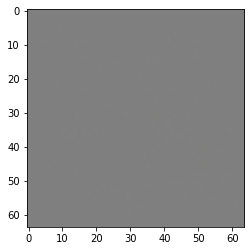

In [5]:
noise = tf.random.normal((1, generator_input_size))
generated_img = generator_model.predict(noise)[0]

plt.imshow(generated_img)

### 4. Preparing dataset

I am going to use.. what?
How about ice cream? Maybe with some topping?
I started with dumplings beacuse I already had them
in colab we could use something else.

In [6]:
!pip install jmd-imagescraper

!mkdir -p images/Dumplings

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached jmd_imagescraper-1.0.2-py3-none-any.whl (12 kB)
  Using cached pathlib-1.0.1.tar.gz (49 kB)
  Preparing metadata (setup.py) ... error
  ERROR: Command errored out with exit status 1:
   command: /usr/local/opt/python@3.9/bin/python3.9 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/fg/xx2z_k855vgd5h06m_51dnsr0000gp/T/pip-install-zvgm0nd5/pathlib_15a574d24cd444eeb908d84819e6d993/setup.py'"'"'; __file__='"'"'/private/var/folders/fg/xx2z_k855vgd5h06m_51dnsr0000gp/T/pip-install-zvgm0nd5/pathlib_15a574d24cd444eeb908d84819e6d993/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'

In [4]:
# from jmd_imagescraper.core import *
# from pathlib import Path
#
root = Path().cwd()/"images"

In [ ]:
# results_no = 400
#
# duckduckgo_search(root, "Dumplings", "dumplings", max_results=results_no)

In [5]:
def show_sample(ds):
    for elem in ds.take(1):
        ds = elem[0]
        imgs = ds[:16].numpy()
        plt.figure(figsize=figsize)
        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(imgs[i])

        plt.show()

In [6]:
seed = 123

rescale = preprocessing.Rescaling(scale=1.0 / 255)

training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    root,
    batch_size=64,
    image_size=(64, 64),
    subset='training',
    label_mode='int',
    validation_split=.2,
    seed=seed
).map(lambda x, y: (rescale(x), y))

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    root,
    batch_size=64,
    image_size=(64, 64),
    subset='validation',
    validation_split=.2,
    label_mode='int',
    seed=seed
).map(lambda x, y: (rescale(x), y))

Found 333 files belonging to 1 classes.
Using 267 files for training.
Found 333 files belonging to 1 classes.
Using 66 files for validation.


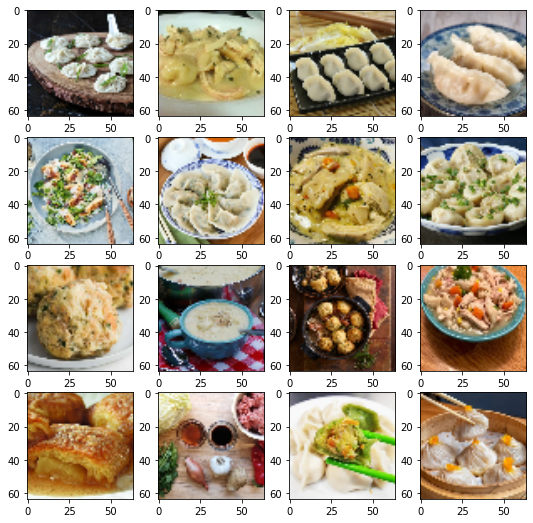

In [12]:
show_sample(training_ds)

### 5. Data augmentation

In [7]:
augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    preprocessing.RandomRotation(0.05)
])

augmented_training_ds = training_ds\
    .map(lambda x, y: (augmentation(x), y),
         num_parallel_calls=tf.data.AUTOTUNE)\
    .prefetch(tf.data.AUTOTUNE)

augmented_validation_ds = training_ds\
    .map(lambda x, y: (augmentation(x), y),
         num_parallel_calls=tf.data.AUTOTUNE)\
    .prefetch(tf.data.AUTOTUNE)


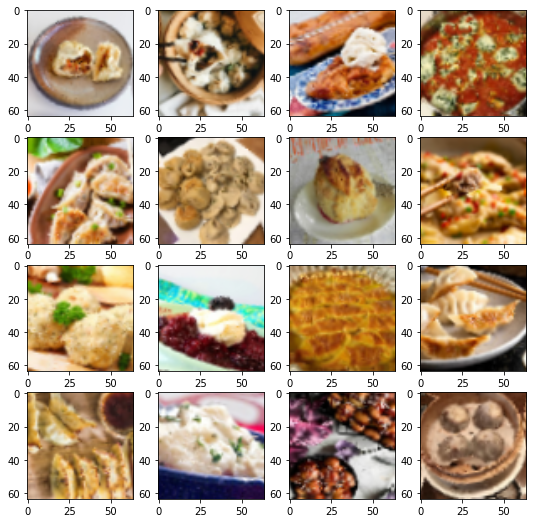

In [144]:
show_sample(augmented_validation_ds)

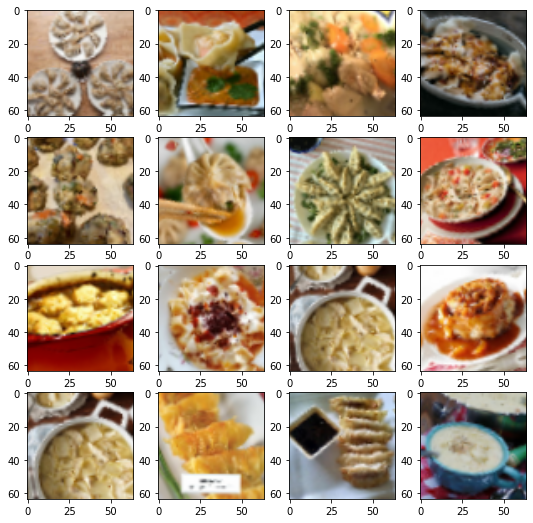

In [145]:
show_sample(augmented_validation_ds)

### 6. Warm up

In [74]:
toy_model = tf.keras.Sequential([
    layers.InputLayer((3,)),
    layers.Dense(3, activation='relu'),
    layers.Dense(1)
])

toy_opt = tf.keras.optimizers.SGD(learning_rate=0.1)

def toy_loss_fn(toy_output):
    return tf.abs(42. - tf.reduce_mean(toy_output))

def toy_train_step(batch):
    with tf.GradientTape() as tape:
        toy_output = toy_model(batch, training=True)
        toy_loss = toy_loss_fn(toy_output)

    train_vars = toy_model.layers[1].trainable_variables
    gradients = tape.gradient(toy_loss, train_vars)
    toy_opt.apply_gradients(zip(gradients, train_vars))

    return toy_loss

def train_toy_model(batch, epochs=10):
    for epoch_i in range(epochs):
        toy_loss = toy_train_step(batch)
        print(f'{epoch_i + 1}. loss={toy_loss}')

In [75]:
batch_size = 16
batch = tf.random.normal([batch_size, 3])

train_toy_model(batch, 9)

1. loss=43.026649475097656
2. loss=42.83680725097656
3. loss=42.646968841552734
4. loss=42.45712661743164
5. loss=42.26728820800781
6. loss=42.077449798583984
7. loss=41.88760757446289
8. loss=41.69776916503906
9. loss=41.50792694091797


### 7. Teaching the discriminator

In [ ]:
# !zip -r /content/file.zip /content/models /content/imgs /content/history
#

In [ ]:
# plot_loss(history)
#

In [ ]:
# plot_accuracy(history)